<a href="https://colab.research.google.com/github/btown29/CeazametAnalysis/blob/main/PipelineCeazamet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import numpy as np
import matplotlib
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import TimeSeriesSplit
import plotly.express as px
import sklearn.utils.class_weight
from datetime import datetime
import scipy.stats
import seaborn
import os
from sklearn.metrics import r2_score
import glob
import xlrd
import datetime as dt
keras = tf.keras


In [ ]:
lista_estaciones = ["Andacollo [[]Collowara[]]", "Coquimbo [[]El Panul[]]", "El Jote", "El Tapado", "Estero Derecho", "Gabriela Mistral", "La Laguna [[]Elqui[]]",
                    "La Polvareda [[]INIA[]]", "La Serena [[]CEAZA[]]", "La Serena [[]Cerro Grande[]]", "La Serena [[]El Romeral[]]",
                    "Las Cardas", "Llano de Las Liebres", "Llanos de Huanta", "Los Corrales", "Pan de Azúcar", "Paso Agua Negra",
                    "Pisco Elqui", "Punta Colorada", "Punta de Choros", "Rivadavia", "Tongoy Balsa CMET", "UCN Guayacan", "Vicuña"]

In [ ]:
pd.read_excel?

In [ ]:
# Creacion DataFrames

estacionesDataFrames = []
for estacion in lista_estaciones:
  files = glob.glob('/content/drive/MyDrive/Electivo Python/Datos/Ceazamet/Datos/Estación '+ estacion + '/*')
  df_aux = pd.DataFrame()
  for file in files:
    df = pd.read_excel(file, skiprows=3, skipfooter=4)
    df['estacion'] = estacion
    df_aux = pd.concat([df, df_aux])
  estacionesDataFrames.append(df_aux)


WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero
*** No CODEPAGE record, no encoding_override: will use 'ascii'
WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero
*** No CODEPAGE record, no encoding_override: will use 'ascii'
WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero
*** No CODEPAGE record, no encoding_override: will use 'ascii'
WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero
*** No CODEPAGE record, no encoding_override: will use 'ascii'
WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero
*** No CODEPAGE record, no encoding_override: will use 'ascii'
WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero
*** No CODEPAGE record, no encoding_override: will use 'ascii'
WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero
*** No CODEPAGE record, no encoding_override: will use 'ascii'
WARNING *** OLE2 inconsistency: SSCS size is 0 b

In [ ]:
estacionesDataFrame = estacionesDataFrames.copy()

In [ ]:

estacionesDataFrame[1]

,[Min] m/s Velocidad de Viento[2m],[Prom] m/s Velocidad de Viento[2m],[Max] m/s Velocidad de Viento[2m],[%Datos] Velocidad de Viento[2m],[Min] m/s Velocidad de Viento[5m],[Prom] m/s Velocidad de Viento[5m],[Max] m/s Velocidad de Viento[5m],[%Datos] Velocidad de Viento[5m],[Min] Â° DirecciÃ³n de viento[2m],[Prom] Â° DirecciÃ³n de viento[2m],[Max] Â° DirecciÃ³n de viento[2m],[%Datos] DirecciÃ³n de viento[2m],[Min] Â° DirecciÃ³n de viento[5m],[Prom] Â° DirecciÃ³n de viento[5m],[Max] Â° DirecciÃ³n de viento[5m],[%Datos] DirecciÃ³n de viento[5m],[Min] umol/mÂ²*s RadiaciÃ³n PAR[0m],[Prom] umol/mÂ²*s RadiaciÃ³n PAR[0m],[Max] umol/mÂ²*s RadiaciÃ³n PAR[0m],[%Datos] RadiaciÃ³n PAR[0m],[Min] W/mÂ² RadiaciÃ³n Solar[2m],[Prom] W/mÂ² RadiaciÃ³n Solar[2m],[Max] W/mÂ² RadiaciÃ³n Solar[2m],[%Datos] RadiaciÃ³n Solar[2m],[Min] hPa PresiÃ³n AtmosfÃ©rica[2m],[Prom] hPa PresiÃ³n AtmosfÃ©rica[2m],[Max] hPa PresiÃ³n AtmosfÃ©rica[2m],[%Datos] PresiÃ³n AtmosfÃ©rica[2m],[Min] mm PrecipitaciÃ³n[1.5m],[Prom] mm PrecipitaciÃ³n[1.5m],[Max] mm PrecipitaciÃ³n[1.5m],[%Datos] PrecipitaciÃ³n[1.5m],[Min] Â°C Temperatura de Suelo[-0.5m],[Prom] Â°C Temperatura de Suelo[-0.5m],[Max] Â°C Temperatura de Suelo[-0.5m],[%Datos] Temperatura de Suelo[-0.5m],[Min] Â°C Temperatura de Suelo[-0.1m],[Prom] Â°C Temperatura de Suelo[-0.1m],[Max] Â°C Temperatura de Suelo[-0.1m],[%Datos] Temperatura de Suelo[-0.1m],[Min] mm EvapotranspiraciÃ³n[0.1m],[Prom] mm EvapotranspiraciÃ³n[0.1m],[Max] mm EvapotranspiraciÃ³n[0.1m],[%Datos] EvapotranspiraciÃ³n[0.1m],[Min] Â°C Punto de RocÃ­o[2m],[Prom] Â°C Punto de RocÃ­o[2m],[Max] Â°C Punto de RocÃ­o[2m],[%Datos] Punto de RocÃ­o[2m],[Min] gd Grados Dia Base 10[2m],[Prom] gd Grados Dia Base 10[2m],[Max] gd Grados Dia Base 10[2m],[%Datos] Grados Dia Base 10[2m],[Min] hf Horas Frio Base 7[2m],[Prom] hf Horas Frio Base 7[2m],[Max] hf Horas Frio Base 7[2m],[%Datos] Horas Frio Base 7[2m],[Min] hf Unidades de Frio Utah[2m],[Prom] hf Unidades de Frio Utah[2m],[Max] hf Unidades de Frio Utah[2m],[%Datos] Unidades de Frio Utah[2m],[Min] V BaterÃ­a[1.5m],[Prom] V BaterÃ­a[1.5m],[Max] V BaterÃ­a[1.5m],[%Datos] BaterÃ­a[1.5m],estacion
Fecha,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2004-03-29 00:00:00,0.012,1.964,3.716,100,1.180,2.711,4.572,100,97.492,97.492,97.492,100,NaN,NaN,NaN,0,0.783,1.424,2.079,100,0.000,0.002,0.007,100,NaN,NaN,NaN,0,0.0,0.0,0.0,100,23.902,23.956,23.989,100,25.371,25.651,25.872,100,0.58,0.58,0.58,2400,NaN,NaN,NaN,0,4.56,4.56,4.56,2400,NaN,NaN,NaN,0,NaN,NaN,NaN,0,NaN,NaN,NaN,0,Coquimbo [[]El Panul[]]
2004-03-29 01:00:00,0.000,0.834,2.470,100,0.192,1.301,3.270,100,110.359,110.359,110.359,100,NaN,NaN,NaN,0,0.391,1.041,1.663,100,0.000,0.003,0.011,100,NaN,NaN,NaN,0,0.0,0.0,0.0,100,23.953,24.006,24.046,100,24.788,25.093,25.369,100,NaN,NaN,NaN,0,NaN,NaN,NaN,0,NaN,NaN,NaN,0,NaN,NaN,NaN,0,NaN,NaN,NaN,0,NaN,NaN,NaN,0,Coquimbo [[]El Panul[]]
2004-03-29 02:00:00,0.000,0.582,1.757,100,0.051,0.885,2.034,100,254.285,254.285,254.285,100,NaN,NaN,NaN,0,0.342,0.961,2.544,100,0.000,0.002,0.011,100,NaN,NaN,NaN,0,0.0,0.0,0.0,100,23.974,24.040,24.079,100,24.202,24.473,24.785,100,NaN,NaN,NaN,0,NaN,NaN,NaN,0,NaN,NaN,NaN,0,NaN,NaN,NaN,0,NaN,NaN,NaN,0,NaN,NaN,NaN,0,Coquimbo [[]El Panul[]]
2004-03-29 03:00:00,0.000,0.035,1.001,100,0.055,0.376,1.211,100,312.789,312.789,312.789,100,NaN,NaN,NaN,0,0.196,0.591,0.954,100,0.000,0.003,0.011,100,NaN,NaN,NaN,0,0.0,0.0,0.0,100,24.030,24.086,24.117,100,23.766,24.009,24.201,100,NaN,NaN,NaN,0,NaN,NaN,NaN,0,NaN,NaN,NaN,0,NaN,NaN,NaN,0,NaN,NaN,NaN,0,NaN,NaN,NaN,0,Coquimbo [[]El Panul[]]
2004-03-29 04:00:00,NaN,NaN,NaN,0,NaN,NaN,NaN,0,NaN,NaN,NaN,0,NaN,NaN,NaN,0,NaN,NaN,NaN,0,NaN,NaN,NaN,0,NaN,NaN,NaN,0,NaN,NaN,NaN,0,NaN,NaN,NaN,0,NaN,NaN,NaN,0,NaN,NaN,NaN,0,NaN,NaN,NaN,0,NaN,NaN,NaN,0,NaN,NaN,NaN,0,NaN,NaN,NaN,0,NaN,NaN,NaN,0,Coquimbo [[]El Panul[]]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,..

In [ ]:
for estaciones in estacionesDataFrame:

    estaciones.rename(columns = {'Unnamed: 0': 'Fecha'}, inplace = True)
    print(estaciones)
    if 'Fecha' in estaciones:
      estaciones.set_index('Fecha', inplace = True)
    estaciones.index= pd.to_datetime(estaciones.index)
    estaciones.index = estaciones.index.sort_values()


                     [Min] Â°C Temperatura del Aire[1.5m]  ...                   estacion
Fecha                                                      ...                           
2021-01-01 00:00:00                                 17.17  ...  Andacollo [[]Collowara[]]
2021-01-01 01:00:00                                 14.52  ...  Andacollo [[]Collowara[]]
2021-01-01 02:00:00                                 13.24  ...  Andacollo [[]Collowara[]]
2021-01-01 03:00:00                                 13.54  ...  Andacollo [[]Collowara[]]
2021-01-01 04:00:00                                 12.87  ...  Andacollo [[]Collowara[]]
...                                                   ...  ...                        ...
2014-12-31 19:00:00                                 18.13  ...  Andacollo [[]Collowara[]]
2014-12-31 20:00:00                                 16.91  ...  Andacollo [[]Collowara[]]
2014-12-31 21:00:00                                 17.65  ...  Andacollo [[]Collowara[]]
2014-12-31

In [ ]:
len(estacionesDataFrame)

24

In [ ]:
numero_horas = 24*365*22
date = pd.to_datetime('2000-01-01')
date = dt.datetime(date.year, date.month, date.day) + dt.timedelta(hours=10)
estacion_prueba = pd.DataFrame(np.random.randint(0,30,size=numero_horas),
                  columns=["Random"],
                  index=pd.date_range(date, freq='60min', periods=numero_horas))

estacion_prueba

,Random
2000-01-01 10:00:00,13
2000-01-01 11:00:00,22
2000-01-01 12:00:00,29
2000-01-01 13:00:00,7
2000-01-01 14:00:00,13
...,...
2021-12-26 05:00:00,17
2021-12-26 06:00:00,13
2021-12-26 07:00:00,6
2021-12-26 08:00:00,21


In [ ]:
for estacion in estacionesDataFrame:
  print(estacion_prueba.head())
  print(estacion.head())
  estacion_prueba = estacion_prueba.merge(estacion, left_index=True, right_index=True)
  print(estacion_prueba.tail())
  input()
estacion_prueba

                     Random  ...                   estacion
2014-01-13 00:00:00      21  ...  Andacollo [[]Collowara[]]
2014-01-13 01:00:00      19  ...  Andacollo [[]Collowara[]]
2014-01-13 02:00:00      17  ...  Andacollo [[]Collowara[]]
2014-01-13 03:00:00      11  ...  Andacollo [[]Collowara[]]
2014-01-13 04:00:00      23  ...  Andacollo [[]Collowara[]]

[5 rows x 74 columns]
                     [Min] Â°C Temperatura del Aire[1.5m]  ...                   estacion
Fecha                                                      ...                           
2014-01-13 00:00:00                                 17.17  ...  Andacollo [[]Collowara[]]
2014-01-13 01:00:00                                 14.52  ...  Andacollo [[]Collowara[]]
2014-01-13 02:00:00                                 13.24  ...  Andacollo [[]Collowara[]]
2014-01-13 03:00:00                                 13.54  ...  Andacollo [[]Collowara[]]
2014-01-13 04:00:00                                 12.87  ...  Andacollo [[]

KeyboardInterrupt: ignored

In [ ]:
# Rango de tiempo para analisis
fecha_inicio = '2018-02-01'
fecha_final  = '2018-02-02'

In [ ]:
plt.hist(bins)

(array([4., 0., 0., 0., 0., 0., 6., 0., 1., 0., 2., 0., 0., 1., 0., 0., 0.,
        1., 1., 0., 4.]),
 array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21]),
 <a list of 21 Patch objects>)

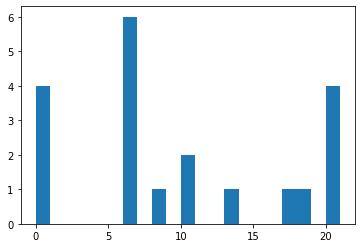

In [ ]:
anios = []
for i in range(22):
  cont = 0
  for estacion in estacionesDataFrame:
    if str(2000 + i) in estacion.index:
      if(i==2):
        print(estacion['estacion'])
      cont += 1
  anios.append(cont)
plt.hist(anios, bins=range(0,22))

In [ ]:
df_nuevo1 = pd.DataFrame()
df_nuevo2 = pd.DataFrame()
for estacion in estacionesDataFrame:
  #print(estacion)
  #input()
  
  if "[Prom] Â°C Temperatura del Aire[1.5m]" in estacion:
    df_aux1 = estacion[["[Prom] Â°C Temperatura del Aire[1.5m]", "estacion" ]]
    df_aux1.index.sort_values()
    df_aux1 = df_aux1[(df_aux1.index > fecha_inicio) & (df_aux1.index <= fecha_final)]
    df_nuevo1 = pd.concat([df_nuevo1, df_aux1])
    print(df_aux1.head())
   
  elif "[Prom] Â°C Temperatura del Aire[2m]" in estacion:
    df_aux2 = estacion[["[Prom] Â°C Temperatura del Aire[2m]", "estacion" ]]
    df_aux2.index.sort_values()
    df_aux2 = df_aux2[(df_aux2.index > fecha_inicio) & (df_aux2.index <= fecha_final)]
    df_nuevo2 = pd.concat([df_nuevo2, df_aux2])
  else:
    print(estacion['estacion'])


                     [Prom] Â°C Temperatura del Aire[1.5m]                   estacion
Fecha                                                                                
2018-02-01 01:00:00                                 19.034  Andacollo [[]Collowara[]]
2018-02-01 02:00:00                                 18.848  Andacollo [[]Collowara[]]
2018-02-01 03:00:00                                 18.217  Andacollo [[]Collowara[]]
2018-02-01 04:00:00                                 17.511  Andacollo [[]Collowara[]]
2018-02-01 05:00:00                                 17.783  Andacollo [[]Collowara[]]
Fecha
2004-03-29 00:00:00    Coquimbo [[]El Panul[]]
2004-03-29 01:00:00    Coquimbo [[]El Panul[]]
2004-03-29 02:00:00    Coquimbo [[]El Panul[]]
2004-03-29 03:00:00    Coquimbo [[]El Panul[]]
2004-03-29 04:00:00    Coquimbo [[]El Panul[]]
                                ...           
2021-02-11 11:00:00    Coquimbo [[]El Panul[]]
2021-02-11 12:00:00    Coquimbo [[]El Panul[]]
2021-02-11 13:00

In [ ]:
df_nuevo1.tail()

,[Prom] Â°C Temperatura del Aire[1.5m],estacion
Fecha,,
2014-02-15 20:00:00,12.648,Andacollo [[]Collowara[]]
2014-02-15 21:00:00,11.713,Andacollo [[]Collowara[]]
2014-02-15 22:00:00,11.148,Andacollo [[]Collowara[]]
2014-02-15 23:00:00,11.075,Andacollo [[]Collowara[]]
2014-02-16 00:00:00,11.275,Andacollo [[]Collowara[]]


In [ ]:
fig = plt.figure()
ax1 = fig.add_axes([0.1, 0.5, 0.8, 0.4],
                   xticklabels=[], ylim=(-1.2, 1.2))
ax2 = fig.add_axes([0.1, 0.1, 0.8, 0.4],
                   ylim=(-1.2, 1.2))

x = np.linspace(0, 10)
ax1.plot(np.sin(x))
ax2.plot(np.cos(x));

In [ ]:
fig, ax = plt.subplots(len(estacionesDataFrame), 1, sharex='col', sharey='row')

In [ ]:
for i in range(len(estacionesDataFrame)):
        ax[i].plot(estacionesDataFrame[i]['Hora_dia'], estacionesDataFrame[i]['Temperatura'])
fig

In [ ]:
cor

In [ ]:
plt.plot(a,b,'o', label='coorelacion'+ str(cor[0,1]))
plt.legend()

In [ ]:
len(nombreEstaciones)

In [ ]:
def crear_dataframe(estaciones_monitoreo, numero_columna, estaciones_nombre ):
    aux = []
    for i in range(len(estaciones_monitoreo)):
        aux.append(estaciones_monitoreo[i].values[:,numero_columna])
    df = pd.DataFrame()
    for j in range(len(estaciones_monitoreo)):
        df[estaciones_nombre[j]] = aux[j]
    df.dropna(inplace = True)
    df = df.astype('float')
    return df



In [ ]:
estaciones =[subconjunto1, subconjunto2]
nombres = ['La Serena', 'Elqui']

In [ ]:
c = crear_dataframe(listaEstaciones, 2, nombreEstaciones)

plt.figure(figsize=(10,10))
plt.matshow(c.corr(), fignum=1)
plt.xticks(range(len(c.columns)), c.columns)
plt.yticks(range(len(c.columns)), c.columns)
plt.colorbar()
plt.show()


In [ ]:
#df = pd.DataFrame(np.random.randn(1000, 2), columns=['A','B'])
pd.plotting.scatter_matrix(c, alpha=1, figsize=(10,10), grid = True)

In [ ]:
def heatmap(data,titulo="", ax=None, cbar_kw={}, cbarlabel="", **kwargs):
    if not ax:
        ax = plt.gca()
    im = ax.imshow(data, **kwargs)
    cbar = ax.figure.colorbar(im, ax=ax, **cbar_kw)
    for edge, spine in ax.spines.items():
        spine.set_visible(False)

    ax.set_xticks(np.arange(data.shape[1]+1)-.5, minor=True)
    ax.set_yticks(np.arange(data.shape[0]+1)-.5, minor=True)
    ax.grid(which="minor", color="black", linestyle='-', linewidth=3)
    ax.set_title(titulo)
    ax.tick_params(which="minor", bottom=False, left=False)

    return im, cbar

def annotate_heatmap(im, data=None, valfmt="{x:.2f}",
                     textcolors=["black", "white"],
                     threshold=None, **textkw):
    if not isinstance(data, (list, np.ndarray)):
        data = im.get_array()
    if threshold is not None:
        threshold = im.norm(threshold)
    else:
        threshold = im.norm(data.max())/2.
    kw = dict(horizontalalignment="center",
              verticalalignment="center")
    kw.update(textkw)
    if isinstance(valfmt, str):
        valfmt = matplotlib.ticker.StrMethodFormatter(valfmt)
    texts = []
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            kw.update(color=textcolors[int(im.norm(data[i, j]) > threshold)])
            text = im.axes.text(j, i, valfmt(data[i, j], None), **kw)
            texts.append(text)
    return texts

In [ ]:
fig, ax = plt.subplots(figsize=(9,9))

im, cbar = heatmap(c.corr(), ax=ax,
                   cbarlabel="Calor posibilidades",titulo="Coorelacion Monitoreo")

texts = annotate_heatmap(im, valfmt="{x:.2f}")

fig.tight_layout()
plt.show()

In [ ]:
pip install simplekml

In [ ]:
from fastkml import  kml
doc = open('C:/Users/Bryan/Desktop/DataScience/ceazamet/Raster/COQ/4.kml').read()
k = kml.KML()
k.from_string(doc)
for f in k.features():
    print(f.name)

In [ ]:
import warnings
import numpy as np
from scipy.spatial.distance import pdist, squareform
import matplotlib.pyplot as plt
import simplekml

In [ ]:
warnings.filterwarnings("ignore")

def minimum_spanning_tree(X, copy_X=True):
    """X are edge weights of fully connected graph"""
    if copy_X:
        X = X.copy()

    if X.shape[0] != X.shape[1]:
        raise ValueError("X needs to be square matrix of edge weights")
    n_vertices = X.shape[0]
    spanning_edges = []

    # initialize with node 0:                                                                                        
    visited_vertices = [0]                                                                                           
    num_visited = 1
    # exclude self connections:
    diag_indices = np.arange(n_vertices)
    X[diag_indices, diag_indices] = np.inf

    while num_visited != n_vertices:
        new_edge = np.argmin(X[visited_vertices], axis=None)
        # 2d encoding of new_edge from flat, get correct indices                                                     
        new_edge = divmod(new_edge, n_vertices)
        new_edge = [visited_vertices[new_edge[0]], new_edge[1]]                                                      
        # add edge to tree
        spanning_edges.append(new_edge)
        visited_vertices.append(new_edge[1])
        # remove all edges inside current tree
        X[visited_vertices, new_edge[1]] = np.inf
        X[new_edge[1], visited_vertices] = np.inf                                                                    
        num_visited += 1
    return np.vstack(spanning_edges)

def test_mst():
    P = np.loadtxt("testdata.csv", delimiter=',', skiprows=1)

    X = squareform(pdist(P))

    edge_list = minimum_spanning_tree(X)
    plt.scatter(P[:, 0], P[:, 1], c='b')

    edges = []
    for edge in edge_list:
        i, j = edge
        plt.plot([P[i, 0], P[j, 0]], [P[i, 1], P[j, 1]], c='b')
        edges.append([(P[i, 0], P[j, 0]), (P[i, 1], P[j, 1])])
    plt.show()

    # Save KML file
    kml = simplekml.Kml()
    for i in range(len(edges)):
        line = kml.newlinestring(name="Track" + str(i + 1), coords=edges[i])
        line.style.linestyle.width = 3
        line.style.linestyle.color = simplekml.Color.red
    kml.save("mst.kml")

if __name__ == "__main__":
    test_mst()

In [ ]:
from scipy.interpolate import interp1d


# Generamos unos datos artificiales para hacer el ejemplo
# A datos_y se le añade "ruido" que simula error de
# medida, añadiendole un valor aleatorio
datos_x = np.arange(0, 0.1, 0.003)
A, k, theta = 10.0, 33.3, np.pi/5.0
y_real = A*np.sin(2*np.pi*k*datos_x + theta)
datos_y = y_real + 2*np.random.randn(len(datos_x))

interpolador_lineal = interp1d(datos_x, datos_y)
interpolador_cubico = interp1d(datos_x, datos_y, kind='cubic')

x_inter = np.linspace(0.01, 0.09, 500)
y_inter_l = interpolador_lineal(x_inter)
y_inter_c = interpolador_cubico(x_inter)

plt.plot(datos_x, datos_y, 'ok', label="Datos")
plt.plot(x_inter, y_inter_l, 'r', label="Interpolación lineal")
plt.plot(x_inter, y_inter_c, 'y', label="Interpolación cúbico")

# Si usamos InterpolatedUnivariateSpline podemos interpolar fuera
# del rango de los datos
from scipy.interpolate import InterpolatedUnivariateSpline

# Array de valores más denso que los datos originales, pero
# dentro del rango de los datos
x_inter = np.linspace(-0.01, 0.11, 500)

interpolador = InterpolatedUnivariateSpline(datos_x, datos_y, k=2)
y_inter_u = interpolador(x_inter)

plt.plot(x_inter, y_inter_u, 'k', lw=0.5, label="Interpolador univariable")

plt.xlim(-0.003, 0.102)
plt.ylim(-14, 15)
plt.legend()

In [ ]:
from scipy import misc
from scipy import ndimage as nd

img = misc.face(gray=True)
shifted_img = nd.shift(img, (50, 50))
shifted_img2 = nd.shift(img, (50, 50), mode='nearest')
rotated_img = nd.rotate(img, 30)

cropped_img = img[50:-50, 50:-50]
zoomed_img = nd.zoom(img, 2)  # Interpola la imagen

zoomed_img.shape
# (1536, 2048)
noisy_img = np.copy(img).astype(np.float)

noisy_img += img.std()*0.5*np.random.standard_normal(img.shape)

blurred_img = nd.gaussian_filter(noisy_img, sigma=3)
median_img = nd.median_filter(blurred_img, size=5)

from scipy import signal
wiener_img = signal.wiener(blurred_img, (5,5))

plt.subplot(221)
plt.imshow(img)

plt.subplot(222)
plt.imshow(blurred_img)

plt.subplot(223)
plt.imshow(median_img)

plt.subplot(224)
plt.imshow(wiener_img)

In [ ]:
from osgeo import gdal
dataset = gdal.Open(filename, gdal.GA_ReadOnly)
dataset

In [ ]:
pip install osgeo

In [ ]:
for estacion in estacionesDataFrame:
  if 'estacion' in estacion:
    aux = estacion['estacion'][0]
    estacion.to_csv('/content/drive/MyDrive/Electivo Python/'+aux+'.csv')